In [7]:
from pathlib import Path
import pandas as pd
pd.set_option('max_rows', 1024)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("deep")

In [8]:
IDNET_PATH = Path(r"C:\Users\Fred\Documents\Insight\Gait Datasets\IDNet Database\IDNet_dataset")

In [121]:
def get_walk_data(user_id, walk_num, hz=60):
    """Return DataFrame of walk sensor data from IDNet individual/walk at 10ms intervals (resampled).
    Note the data may include NaN values since sensors are sampled at different frequencies or may skip measurements."""
    # Retrieve folder
    walkid = f"u{str(user_id).zfill(3)}_w{str(walk_num).zfill(3)}"
    folder = IDNET_PATH / walkid
    # For each sensor log, construct df from file
    dfs = []
    for log in folder.glob("*.log"):
        logtype = log.stem.split("_")[-1]  # accelerometer, gyroscope, etc.
        if logtype == "magnetometer":
            continue  # Skip magnetometer since not probably not useful
        df = pd.read_csv(log, sep="\t")
        # Read timestamp column as pandas Timedelta, starting from 0 ns
        df[f"{logtype}_timestamp"] = pd.to_timedelta(df[f"{logtype}_timestamp"], unit="ns")
        df = df.rename(columns={f"{logtype}_timestamp": "timestamp"})
        df = df.set_index("timestamp")
        dfs.append(df)
    merged_df = pd.concat(dfs, axis="columns")
    # Truncate each dataframe based on latest start / earliest end
    # Alternatively, truncate up to 10s from beginning and end to exclude for start/stop motions
    latest_start_time = max(merged_df.notna().idxmax().max(), merged_df.index[0] + pd.Timedelta("10s"))
    earliest_end_time = min(merged_df.notna()[::-1].idxmax().min(), merged_df.index[-1] - pd.Timedelta("10s"))
    # Sensors have different sampling freqs so resample
    merged_df = merged_df.resample(f"{round(1/hz * 1e9)}N").mean()
    merged_df = merged_df.loc[latest_start_time: earliest_end_time].copy()
    # Impute NaN values which are just resulting from a single skip
    merged_df = merged_df.fillna(method='pad', limit=3, axis=1)
    # Convert timestamp to relative times
    merged_df = merged_df.set_index(merged_df.index - merged_df.index[0])
    return merged_df

In [284]:
df = get_walk_data(3, 1)
df

,accelerometer_x_data,accelerometer_y_data,accelerometer_z_data,gravity_x_data,gravity_y_data,gravity_z_data,gyroscope_x_data,gyroscope_y_data,gyroscope_z_data,linearaccelerometer_x_data,linearaccelerometer_y_data,linearaccelerometer_z_data,rotvec_x_data,rotvec_y_data,rotvec_z_data
timestamp,,,,,,,,,,,,,,,
00:00:00,-2.108543,-8.566605,0.407181,0.046391,-9.739213,1.145575,-1.475784,0.029007,-0.486577,-0.676213,1.722519,-1.467486,-0.663411,0.038370,-0.046700
00:00:00.016666,-1.803841,-8.498444,-0.637421,0.103924,-9.759982,0.949072,-1.709951,-0.159144,-0.556208,-2.843566,0.915535,-0.228552,-0.671020,0.036619,-0.048223
00:00:00.033333,-0.590782,-8.829330,0.689728,0.175198,-9.783282,0.649032,-1.687038,0.771389,-0.342209,-1.357904,1.145248,-0.847709,-0.682340,0.036237,-0.051759
00:00:00.050000,-0.200684,-9.505050,2.484306,0.216924,-9.798564,0.329357,-1.643972,1.802124,-0.213720,-0.522788,0.346807,1.971531,-0.693711,0.044312,-0.061680
00:00:00.066666,-0.519356,-9.894890,2.337372,0.238562,-9.802806,0.128560,-1.555608,1.829402,-0.205994,-0.410317,-0.007471,2.424177,-0.700408,0.053550,-0.071495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:39.983344,7.229042,-1.279419,0.817696,-0.371140,-9.052018,3.754011,0.450857,1.512975,0.287165,8.427373,8.193684,-1.983351,-0.175096,0.527193,-0.777721
00:09:40.000011,2.513390,-4.547607,-6.250519,-0.384197,-9.057591,3.739186,-0.390175,-0.147633,0.015739,5.237341,6.236277,-6.310817,-0.172930,0.528627,-0.778202
00:09:40.016678,0.589638,-9.551704,-10.052117,-0.297621,-9.125227,3.578716,-0.847000,-0.394526,-0.659648,1.133700,1.429588,-13.254145,-0.180205,0.533904,-0.773702


In [222]:
# Sample sequences from walk
def generate_walk_chunks(df, chunksize=512, is_valid=True):
    """Split df into multiple chunks of data. If is_valid is True, only yields non-NAN data (e.g. ignores sensor skips).
    Chunk size recommended to be power-of-2 for downstream FFT: https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    """
    count = 0
    while count < (len(df) - chunksize):
        subdf = df.iloc[count:count + chunksize, :]
        if not subdf.isna().any(axis=None):  # Return only non-NA
            yield subdf
        count += chunksize

In [238]:
chunk_generator = generate_walk_chunks(df)

In [244]:
chunk = next(chunk_generator)

In [240]:
def plot_log(df, logtype):
    f, ax = plt.subplots(figsize=(15, 5))
    df = df[[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data"]].copy()
    df["mag"] = np.linalg.norm(df.values, axis=1)
    df.plot.line(y=[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data", "mag"], ax=ax)
    ax.set_ylabel(f"{logtype}")
    ax.set_xlabel("Time")
    ax.legend(["x", "y", "z", "mag"], loc="best")
    sns.despine()

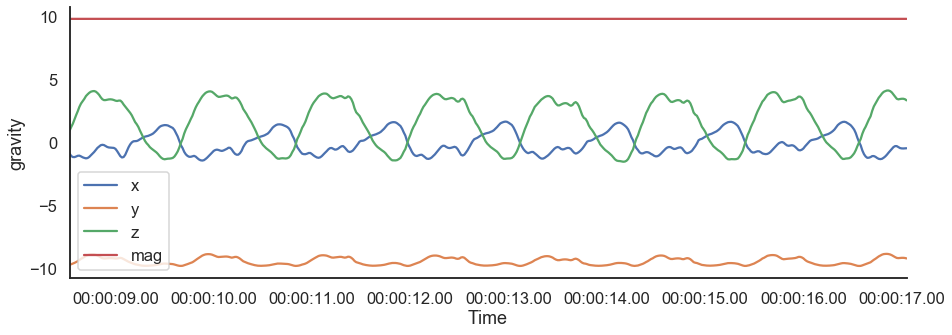

In [268]:
plot_log(chunk, "gravity")

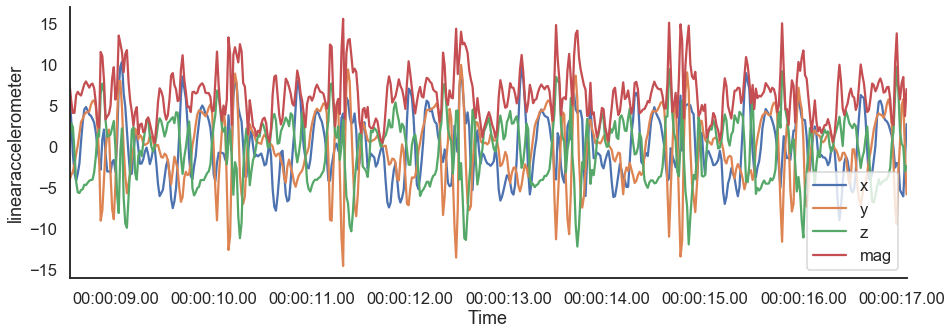

In [288]:
plot_log(chunk, "linearaccelerometer")

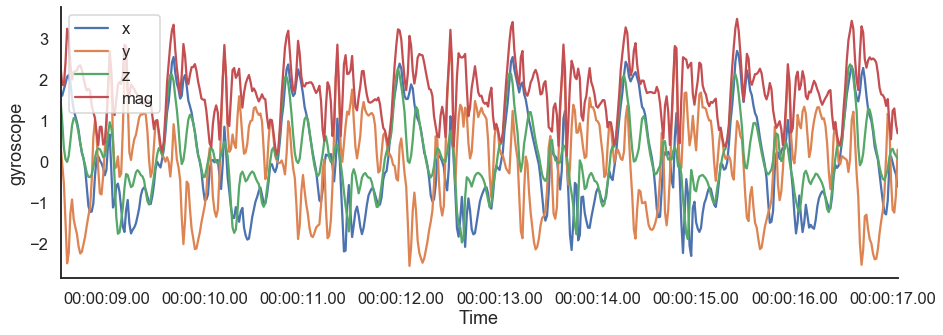

In [270]:
plot_log(chunk, "gyroscope")

## Fourier analysis

In [271]:
def get_normalized_sensor_data(df, logtype):
    norm_acc = np.linalg.norm(df[[f"{logtype}_x_data", f"{logtype}_y_data", f"{logtype}_z_data"]].values, axis=1)
    norm_acc = (norm_acc - norm_acc.mean()) / (np.percentile(norm_acc, 99) - np.percentile(norm_acc, 1))
    return norm_acc

In [131]:
from scipy.fft import fft, ifft
from scipy.signal import correlate, find_peaks, spectrogram

In [132]:
f_s = 60  # Sampling rate of 60 Hz
f_s

60

In [133]:
def get_fft(signal, f_s):
    """f_s = sampling rate (measurements/second)"""
    T = 1/f_s
    N = len(signal)
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])  # take abs (remove phase component)
    return f_values, fft_values

In [134]:
def get_top_signal_peaks(x, y, n):
    peak_idx, peak_props = find_peaks(y, height=0)  # Specify height to force peak height computation
    peak_heights, peak_idx = zip(*sorted(zip(peak_props["peak_heights"], peak_idx), reverse=True)[:n])
    return x[list(peak_idx)], np.array(peak_heights)

In [135]:
def plot_fft(f_s, *signals):
    f, ax = plt.subplots(figsize=(15, 5))
    f_vals = []
    fft_vals = []
    for i, signal in enumerate(signals):
        f_val, fft_val = get_fft(signal, f_s)
        f_vals.append(f_val)
        fft_vals.append(fft_val)
        ax.plot(f_val, fft_val, "--" if i%2==1 else "-", label=i)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    sns.despine()
    return list(zip(f_vals, fft_vals))

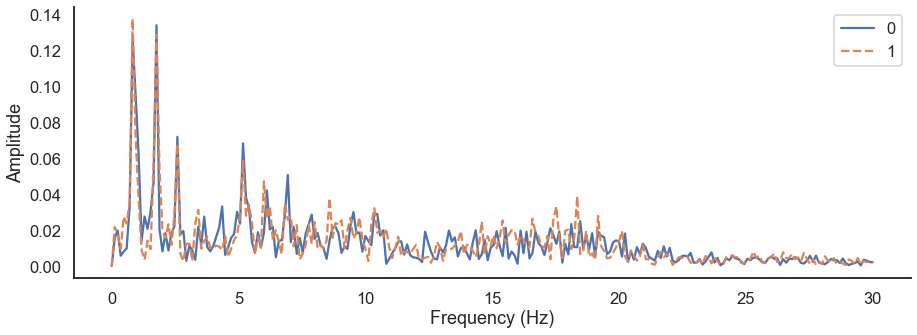

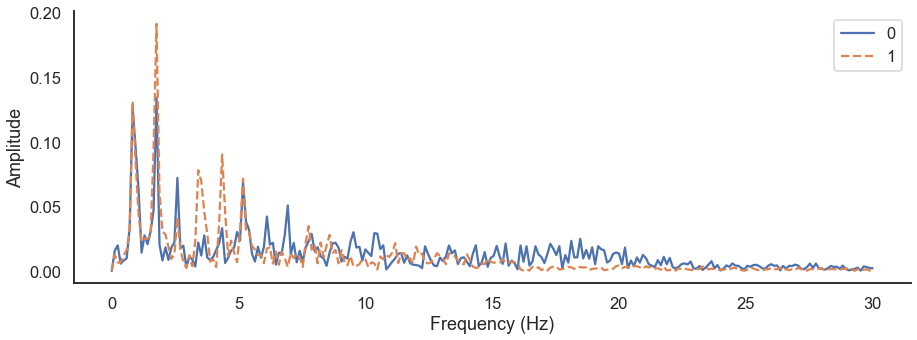

In [171]:
# plot subsequences within the same walk
norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
next_chunk = next(chunk_generator)
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, get_normalized_sensor_data(next_chunk, "linearaccelerometer"))
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, get_normalized_sensor_data(next_chunk, "gyroscope"))

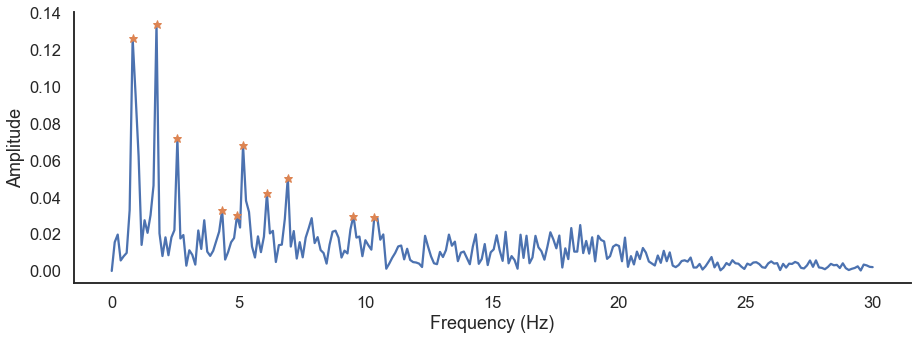

In [172]:
f, ax = plt.subplots(figsize=(15, 5))
f_val, fft_val = get_fft(norm_acc, f_s)
ax.plot(f_val, fft_val)
ax.plot(*get_top_signal_peaks(f1, fft1, 10), "*")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
sns.despine()

In [285]:
# checking that frequencies are unchanging across the entire walk recording
freq, time, Sxx = spectrogram(get_normalized_sensor_data(df, "linearaccelerometer"), f_s)

Text(0.5, 0, 'Time (sec)')

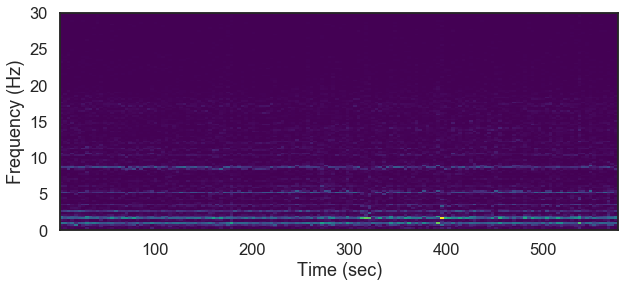

In [287]:
f, ax = plt.subplots(figsize=(10, 4))
ax.pcolormesh(time, freq, Sxx, cmap="viridis")
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (sec)")

## Convert data to feature vectors

- Iterate over users
- Chunk recording information and convert to feature (linearaccelerometer + gyroscope data)
- Label feature with user and walk number

In [139]:
# Get number of walks per user
counts = {}
for folder in IDNET_PATH.glob("*"):
    user_id = int(folder.stem[1:4])
    if user_id not in counts:
        counts[user_id] = 1
    else:
        counts[user_id] += 1

In [140]:
users_with_multiple_walks = [user for user, count in counts.items() if count > 1]
len(users_with_multiple_walks)

31

In [312]:
def create_features_from_fft_peaks(n_peaks=10):
    """Create DataFrame of feature vectors using Fourier peaks."""
    features = []
    for user in tqdm(users_with_multiple_walks, desc="User"):
        for walk in range(1, counts[user]+1):
            df = get_walk_data(user, walk)
            for chunk in generate_walk_chunks(df):
                norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
                norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
                f_acc, fft_acc = get_fft(norm_acc, f_s)
                peak_f_acc, peak_fft_acc = get_top_signal_peaks(f_acc, fft_acc, n_peaks)
                f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
                peak_f_gyro, peak_fft_gyro = get_top_signal_peaks(f_gyro, fft_gyro, n_peaks)
                # concatenate the features
                feature_vector = np.concatenate([[user, walk], peak_f_acc, peak_fft_acc, peak_f_gyro, peak_fft_gyro])
                features.append(feature_vector)

    df_features = pd.DataFrame(features, 
        columns=["user_id", "walk_id", 
               *[f"acc_f{i}" for i in range(n_peaks)], *[f"acc_fft{i}" for i in range(n_peaks)],
               *[f"gyro_f{i}" for i in range(n_peaks)], *[f"gyro_fft{i}" for i in range(n_peaks)]
    ])
    df_features["user_id"] = df_features["user_id"].astype(int)
    df_features["walk_id"] = df_features["walk_id"].astype(int)
    return df_features

In [142]:
def create_features_from_fft_raw():
    """Create DataFrame of feature vectors using raw Fourier spectrum."""
    features = []
    for user in tqdm(users_with_multiple_walks, desc="User"):
        for walk in range(1, counts[user]+1):
            df = get_walk_data(user, walk)
            for chunk in generate_walk_chunks(df):
                norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
                norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
                f_acc, fft_acc = get_fft(norm_acc, f_s)
                f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
                # concatenate the features
                feature_vector = np.concatenate([[user, walk], fft_acc, fft_gyro])
                features.append(feature_vector)

    df_features = pd.DataFrame(features, 
        columns=["user_id", "walk_id", 
               *[f"acc_fft{i}" for i in range(len(fft_gyro))],
               *[f"gyro_fft{i}" for i in range(len(fft_gyro))],
    ])
    df_features["user_id"] = df_features["user_id"].astype(int)
    df_features["walk_id"] = df_features["walk_id"].astype(int)
    return df_features

In [313]:
# df_features = create_features_from_fft_raw()
df_features = create_features_from_fft_peaks(5)  # I get better accuracy using peaks as features (less overfitting)

In [314]:
df_features.head()

,user_id,walk_id,acc_f0,acc_f1,acc_f2,acc_f3,acc_f4,acc_fft0,acc_fft1,acc_fft2,...,gyro_f0,gyro_f1,gyro_f2,gyro_f3,gyro_f4,gyro_fft0,gyro_fft1,gyro_fft2,gyro_fft3,gyro_fft4
0,1,1,1.764706,2.705882,0.941176,4.470588,8.941176,0.100588,0.094342,0.076939,...,1.764706,0.941176,2.705882,3.647059,5.411765,0.120997,0.114568,0.070393,0.054650,0.042814
1,1,1,1.764706,2.705882,4.470588,0.941176,6.941176,0.080661,0.079577,0.053687,...,0.941176,1.764706,2.705882,0.588235,3.294118,0.140728,0.112847,0.078510,0.044486,0.043454
2,1,1,1.882353,0.941176,2.823529,4.588235,2.588235,0.094938,0.077178,0.061089,...,0.941176,1.882353,2.823529,0.705882,3.647059,0.128348,0.094436,0.059027,0.042902,0.042354
3,1,1,1.882353,4.588235,2.823529,0.941176,9.176471,0.083576,0.073425,0.061987,...,0.941176,1.882353,2.705882,6.470588,3.647059,0.160637,0.106089,0.067237,0.067148,0.062007
4,1,1,1.882353,2.705882,0.941176,4.588235,9.176471,0.080900,0.080248,0.072879,...,0.941176,1.764706,3.647059,2.705882,6.352941,0.141861,0.109169,0.100240,0.081770,0.046791


## Fit data to initial classification model

- Make sure when splitting into training/test data that we don't mix walks in either set (leakage)
- This is just to test if the individuals can indeed be resolved

In [315]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [316]:
train = df_features[df_features["walk_id"] == 1].copy()
y_train, X_train = train.iloc[:, 0], train.iloc[:, 2:]
test = df_features[df_features["walk_id"] != 1].copy()
y_test, X_test = test.iloc[:, 0], test.iloc[:, 2:]

#### random forest

In [317]:
trees = RandomForestClassifier(class_weight="balanced")

In [318]:
trees.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [319]:
train["predicted_user"] = trees.predict(X_train)
test["predicted_user"] = trees.predict(X_test)

Text(0.5, 1.0, 'Training set confusion matrix')

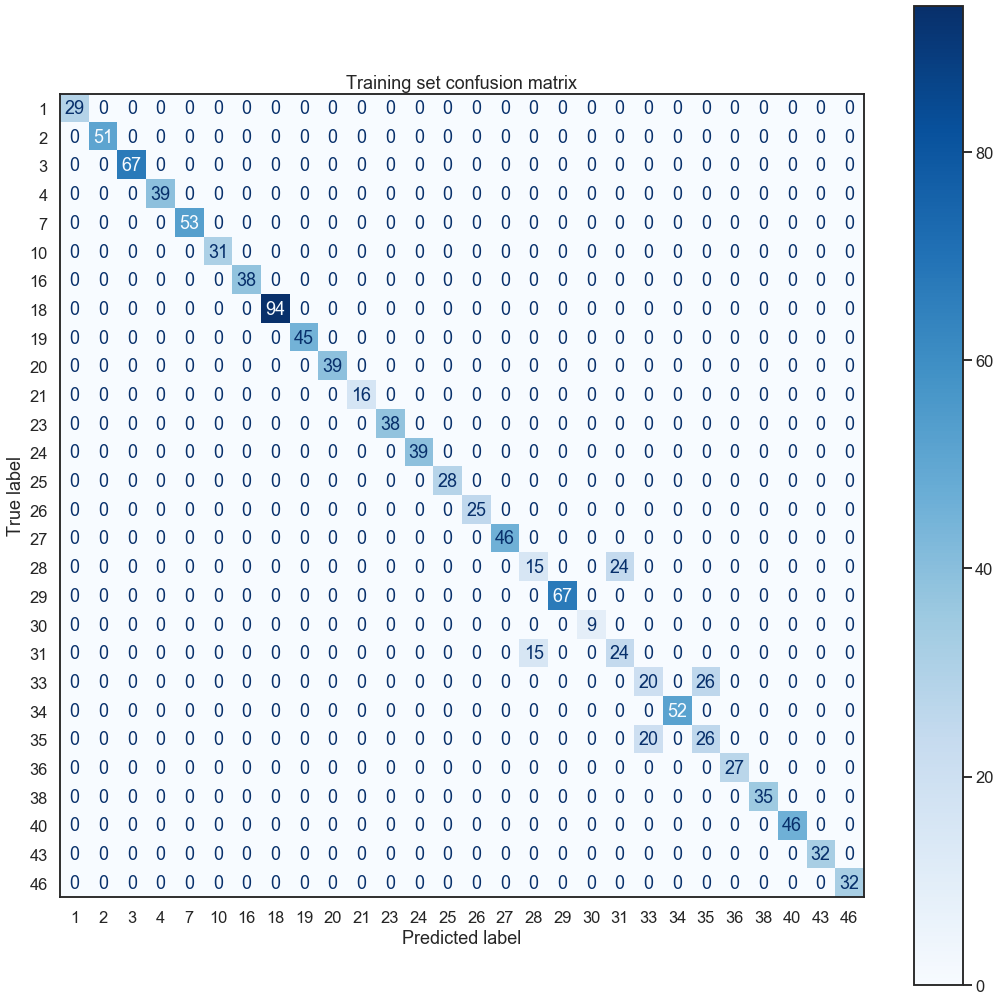

In [320]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_train, y_train, ax=ax, cmap="Blues")
ax.set_title("Training set confusion matrix")
# ax.images[-1].colorbar.remove()

Text(0.5, 1.0, 'Test set confusion matrix')

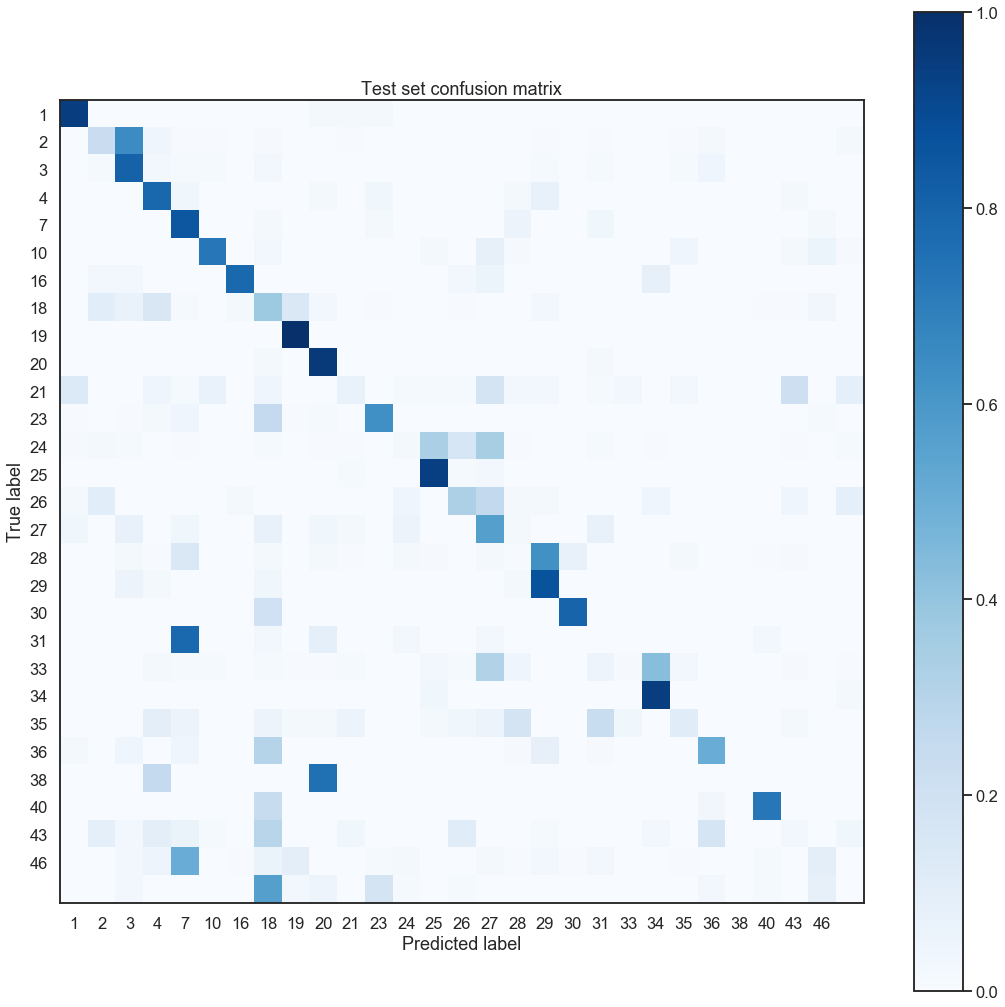

In [321]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_test, y_test, ax=ax, cmap="Blues", normalize="true", include_values=False)
ax.set_title("Test set confusion matrix")

In [322]:
# report accuracy
cm = metrics.confusion_matrix(y_test, test["predicted_user"])

In [323]:
print(f"Accuracy: {cm.trace() / cm.sum():.2%}")

Accuracy: 39.26%


In [324]:
np.triu(cm,1).sum(), np.tril(cm,-1).sum()

(992, 1114)

In [325]:
metrics.precision_score(y_test, test["predicted_user"], average="micro")

0.39255840784539947

## Compute similarity scores

- basic idea for now is to normalize features and do a cosine similarity
- pool maximum similarity

In [326]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [327]:
# Need to normalize across features
# scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()

In [328]:
scaled_features = scaler.fit_transform(df_features.iloc[:,2:])  # features should be columns

In [329]:
multiindex = df_features.set_index(["user_id", "walk_id"]).index
normed = pd.DataFrame(scaled_features, columns=df_features.columns[2:], index=multiindex)
normed.head()

acc_f0    acc_f1    acc_f2    acc_f3    acc_f4  acc_fft0  \
user_id walk_id                                                               
1       1        1.409392  0.035453 -1.648323 -0.630819  0.666224 -1.597236   
        1        1.409392  0.035453 -0.461230 -1.813894  0.047236 -2.557501   
        1        1.661636 -0.719464 -1.015207 -0.591383 -1.299974 -1.869487   
        1        1.661636  0.840697 -1.015207 -1.813894  0.739046 -2.417000   
        1        1.661636  0.035453 -1.648323 -0.591383  0.739046 -2.545964   

                 acc_fft1  acc_fft2  acc_fft3  acc_fft4   gyro_f0   gyro_f1  \
user_id walk_id                                                               
1       1       -0.045291  0.475521  0.723130  0.884953 -0.183732 -1.182284   
        1       -0.809633 -1.143082 -0.893757 -1.808056 -1.731437 -0.692960   
        1       -0.933866 -0.627782  0.008622 -0.015347 -1.731437 -0.623056   
        1       -1.128119 -0.565311 -0.182628  0.426541 -1.731437 -0.623056   
        1       -0.774887  0.192896  1.010878  1.367825 -1.731437 -0.692960   

                  gyro_f2   gyro_f3   gyro_f4  gyro_fft0  gyro_fft1  \
user_id walk_id                                                       
1       1       -0.515858 -0.258835  0.041815  -1.319088   0.425803   
        1       -0.515858 -1.481577 -0.713467  -0.843930   0.347828   
        1       -0.457433 -1.434549 -0.587587  -1.142062  -0.486490   
        1       -0.515858  0.869850 -0.587587  -0.364499   0.041570   
        1       -0.048461 -0.635064  0.377496  -0.816655   0.181157   

                 gyro_fft2  gyro_fft3  gyro_fft4  
user_id walk_id                                   
1       1        -0.764764  -1.069710  -1.452913  
        1        -0.278124  -1.869714  -1.394252  
        1        -1.446244  -1.994420  -1.495023  
        1        -0.953998  -0.086056   0.306496  
        1         1.024714   1.064773  -1.088362

In [330]:
# Using euclidean distances instead... (normalize simi by 1/1+d?)
# simi = pd.DataFrame(euclidean_distances(df_features.iloc[:,2:].set_index(multiindex)), index=multiindex, columns=multiindex)

In [331]:
simi = pd.DataFrame(cosine_similarity(normed), index=multiindex, columns=multiindex)
# understand why values are negative here

In [332]:
simi.head()

user_id                1                                                     \
walk_id                 1         1         1         1         1         1   
user_id walk_id                                                               
1       1        1.000000  0.543711  0.677361  0.594260  0.693583  0.666188   
        1        0.543711  1.000000  0.807545  0.632792  0.433691  0.872173   
        1        0.677361  0.807545  1.000000  0.552807  0.473167  0.777096   
        1        0.594260  0.632792  0.552807  1.000000  0.647326  0.719723   
        1        0.693583  0.433691  0.473167  0.647326  1.000000  0.488726   

user_id                                                  ...        46  \
walk_id                 1         1         1         1  ...         3   
user_id walk_id                                          ...             
1       1        0.650250  0.614727  0.734698  0.755815  ...  0.036562   
        1        0.777910  0.503157  0.771417  0.711052  ... -0.446678   
        1        0.749668  0.703103  0.703352  0.630682  ... -0.256305   
        1        0.686714  0.475887  0.640209  0.673464  ... -0.093414   
        1        0.727086  0.542404  0.574731  0.612375  ...  0.098858   

user_id                                                                      \
walk_id                 3         3         3         3         3         3   
user_id walk_id                                                               
1       1        0.087685  0.038380  0.049763  0.014012  0.405907  0.215691   
        1       -0.287172 -0.249435 -0.241712 -0.015840 -0.078262 -0.070625   
        1       -0.116149 -0.203709 -0.204253 -0.110020 -0.000460  0.016478   
        1        0.011943  0.077509  0.067672  0.398049  0.163265  0.175730   
        1        0.184048  0.167385  0.233788  0.115077  0.492025  0.154920   

user_id                                        
walk_id                 3         3         3  
user_id walk_id                                
1       1        0.278477  0.114069  0.174084  
        1       -0.099584 -0.276319 -0.108771  
        1       -0.159775 -0.178977 -0.270599  
        1        0.260278 -0.174337  0.161580  
        1        0.158015  0.082740  0.189490  

[5 rows x 4615 columns]

In [333]:
pd.Series(simi.loc[(2,1),(1,1)].values.ravel()).mean()

-0.041916122024994014

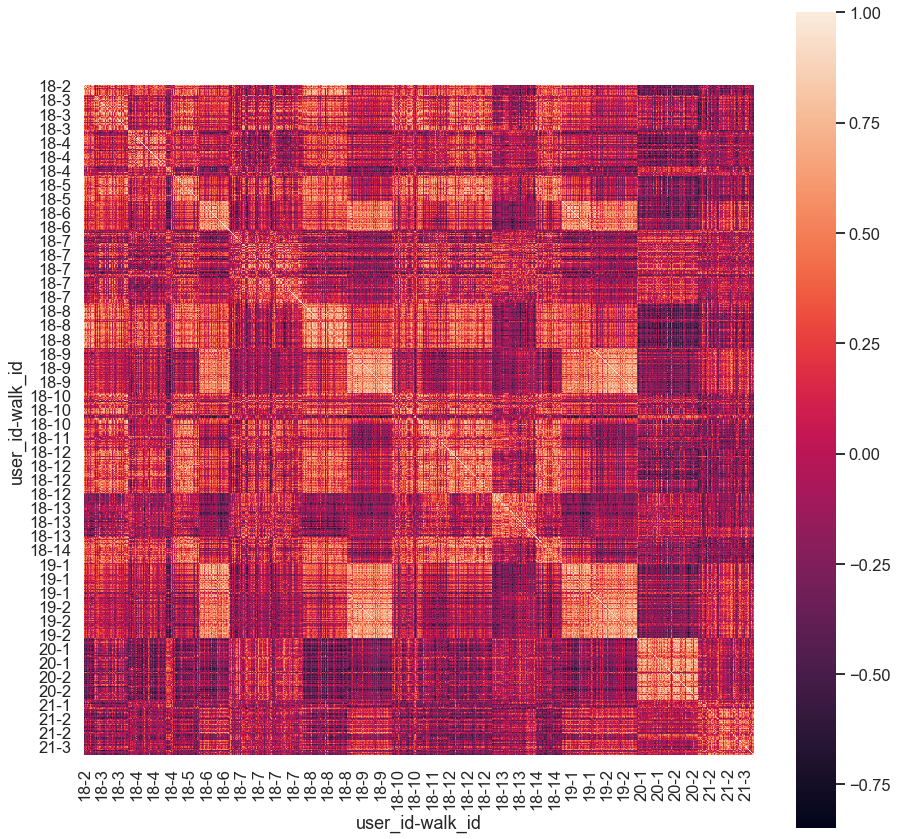

In [334]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(simi.iloc[1000:2000,1000:2000], square=True, ax=ax)

In [335]:
# Pool simi by mean similarity over the entire walks being compared
# Note before doing this we need to NaN the diagonal values so that they aren't counted in the mean
np.fill_diagonal(simi.values, np.nan)
pool = simi.groupby(by=["user_id", "walk_id"], axis=0).mean().groupby(by=["user_id", "walk_id"], axis=1).mean()
pool.head()

user_id                1                             2                       \
walk_id                 1         2         3         1         2         3   
user_id walk_id                                                               
1       1        0.577635  0.410352  0.480732 -0.041916  0.125714  0.006598   
        2        0.410352  0.610981  0.530214  0.016567 -0.127849 -0.088545   
        3        0.480732  0.530214  0.641113  0.088633 -0.017183  0.099062   
2       1       -0.041916  0.016567  0.088633  0.481855  0.041903  0.372473   
        2        0.125714 -0.127849 -0.017183  0.041903  0.336090  0.061382   

user_id                          3                   4   ...        40  \
walk_id                 4         1         2         1  ...         3   
user_id walk_id                                          ...             
1       1        0.037069  0.125714  0.037069 -0.029339  ...  0.085344   
        2       -0.159061 -0.127849 -0.159061 -0.168211  ...  0.343351   
        3       -0.070864 -0.017183 -0.070864 -0.062373  ...  0.330199   
2       1        0.036622  0.041903  0.036622  0.066539  ...  0.210471   
        2        0.330643  0.345999  0.330643 -0.041159  ... -0.076873   

user_id                          43                                          \
walk_id                 4         1         2         3         4         5   
user_id walk_id                                                               
1       1        0.152802  0.042214 -0.125378 -0.105838  0.043504 -0.070795   
        2        0.170609 -0.088497 -0.420624  0.008187 -0.044383 -0.255830   
        3        0.301087 -0.084349 -0.388287 -0.031152 -0.093899 -0.173555   
2       1        0.154274 -0.185225 -0.115043  0.079274 -0.051405 -0.179324   
        2       -0.085046  0.160525  0.234447 -0.098445  0.058285 -0.022131   

user_id                46                      
walk_id                 1         2         3  
user_id walk_id                                
1       1        0.166618  0.147855  0.103621  
        2        0.270561  0.166933 -0.042378  
        3        0.266052  0.192614 -0.035971  
2       1        0.190157 -0.016484 -0.158126  
        2       -0.003200  0.045054  0.092095  

[5 rows x 111 columns]

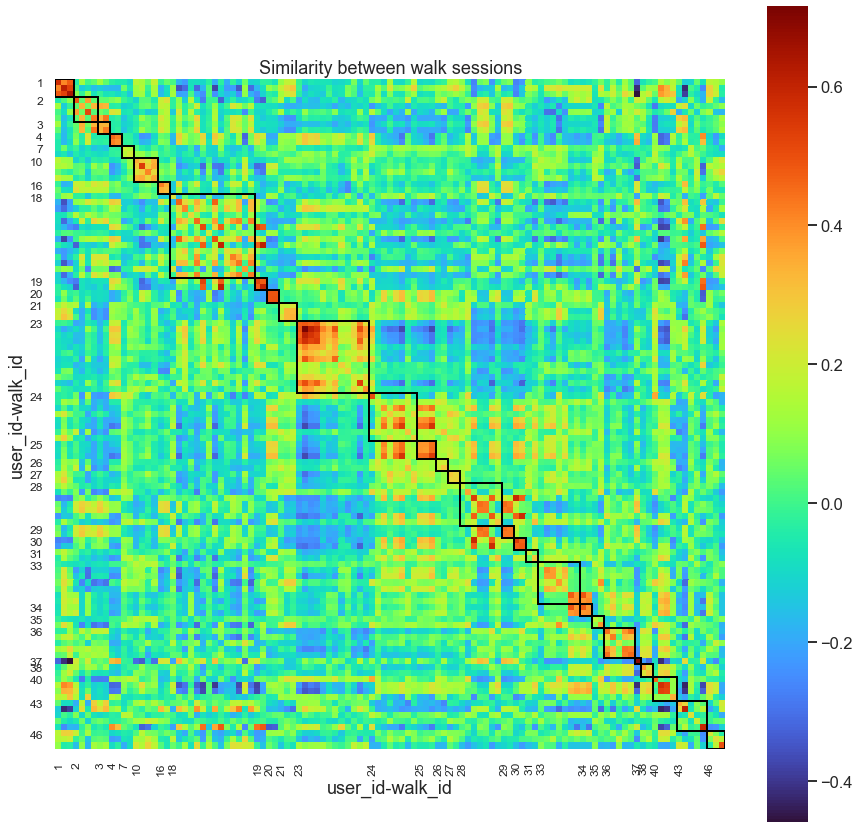

In [336]:
f, ax = plt.subplots(figsize=(15,15))
# Get indices of each user in pool and number of walks for each so we can highlight same-user groups
groups = [(pool.index.get_loc((subdf.iloc[0]["user_id"], subdf.iloc[0]["walk_id"])), len(subdf["walk_id"].unique())) 
          for user, subdf in df_features.groupby("user_id")]
# Get ticklabels
ticklabels = []
for group, group_sz in groups:
    ticklabels.append(pool.index[group][0])
    for i in range(1, group_sz):
        ticklabels.append('')

sns.heatmap(pool, square=True, ax=ax, cmap="turbo", xticklabels=ticklabels, yticklabels=ticklabels)
ax.tick_params(axis='both', which='major', labelsize=12)

# Draw boxes around each group
for group, group_sz in groups:
    rect = patches.Rectangle((group, group), group_sz, group_sz, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Similarity between walk sessions")
plt.show()

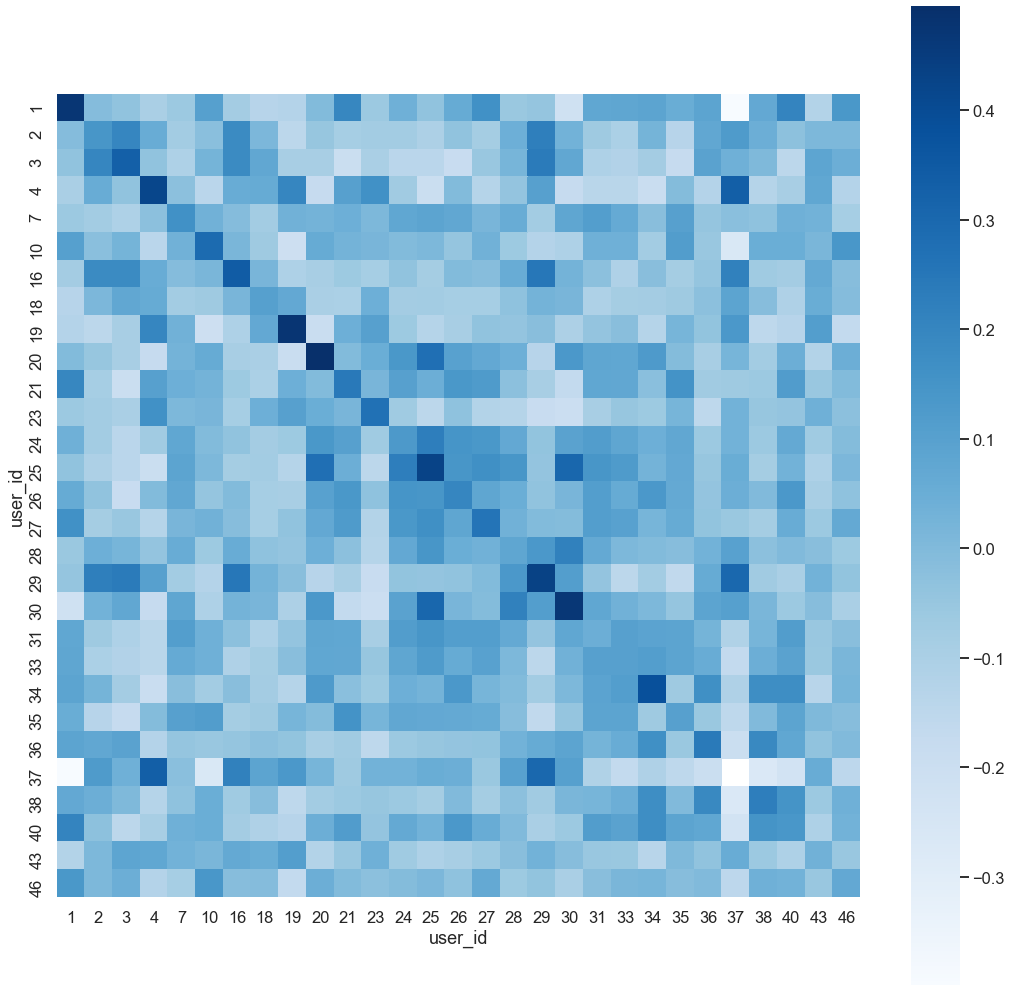

In [337]:
f, ax = plt.subplots(figsize=(18,18))
np.fill_diagonal(pool.values, np.nan)
poolpool = pool.groupby("user_id", axis=0).mean().groupby("user_id", axis=1).mean()
sns.heatmap(poolpool, square=True, cmap="Blues")

In [338]:
def create_fft_peak_features_from_chunk(chunk, n_peaks):
    norm_acc = normalize_sensor_data(chunk, "linearaccelerometer")
    norm_gyro = normalize_sensor_data(chunk, "gyroscope")
    f_acc, fft_acc = get_fft(norm_acc, f_s)
    peak_f_acc, peak_fft_acc = get_top_signal_peaks(f_acc, fft_acc, n_peaks)
    f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
    peak_f_gyro, peak_fft_gyro = get_top_signal_peaks(f_gyro, fft_gyro, n_peaks)
    # concatenate the features
    feature_vector = np.concatenate([peak_f_acc, peak_fft_acc, peak_f_gyro, peak_fft_gyro])
    return feature_vector

In [339]:
normalize_sensor_data = get_normalized_sensor_data

In [340]:
# Imagine an input walk recording which is chunked
# Compute similarity against reference dataset
new_walk = get_walk_data(1, 1)
chunks = generate_walk_chunks(new_walk)
# def create_features_from_fft_peaks(n_peaks=10):
features = []
for chunk in chunks:
    features.append(create_fft_peak_features_from_chunk(chunk, 10))
df_new = pd.DataFrame(features, 
    columns=[*[f"acc_f{i}" for i in range(10)], *[f"acc_fft{i}" for i in range(10)],
           *[f"gyro_f{i}" for i in range(10)], *[f"gyro_fft{i}" for i in range(10)]
])

In [341]:
simi_to_ref = pd.DataFrame(cosine_similarity(normed, scaler.transform(df_new)), index=multiindex)
simi_to_ref = (simi_to_ref + 1)/2  # rescale from -1 to 1 to 0 to 1
simi_to_ref.groupby("user_id").mean().mean(axis=1).sort_values(ascending=False)

ValueError: operands could not be broadcast together with shapes (29,40) (20,) (29,40) 

In [292]:

pd.DataFrame(simi_to_ref.groupby("user_id").mean().mean(axis=1).sort_values(ascending=False), columns=["Score"]).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Score</th>\n    </tr>\n    <tr>\n      <th>user_id</th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1</th>\n      <td>0.717070</td>\n    </tr>\n    <tr>\n      <th>40</th>\n      <td>0.570926</td>\n    </tr>\n    <tr>\n      <th>38</th>\n      <td>0.566829</td>\n    </tr>\n    <tr>\n      <th>26</th>\n      <td>0.562242</td>\n    </tr>\n    <tr>\n      <th>10</th>\n      <td>0.553433</td>\n    </tr>\n    <tr>\n      <th>35</th>\n      <td>0.551320</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>0.540472</td>\n    </tr>\n    <tr>\n      <th>21</th>\n      <td>0.537381</td>\n    </tr>\n    <tr>\n      <th>7</th>\n      <td>0.533832</td>\n    </tr>\n    <tr>\n      <th>29</th>\n      <td>0.530744</td>\n    </tr>\n    <tr>\n      <th>36</th>\n      <td>0.530096</td>\n    </tr>\n    <tr>\n      <th>46</th>\n      <td>0.521490</td>\n    </tr>\n 

## other stuff

In [136]:
from sklearn.manifold import TSNE

In [45]:
tsne = TSNE().fit_transform(scaled_features)

In [46]:
normed["TSNE1"] = tsne[:,0]
normed["TSNE2"] = tsne[:,1]

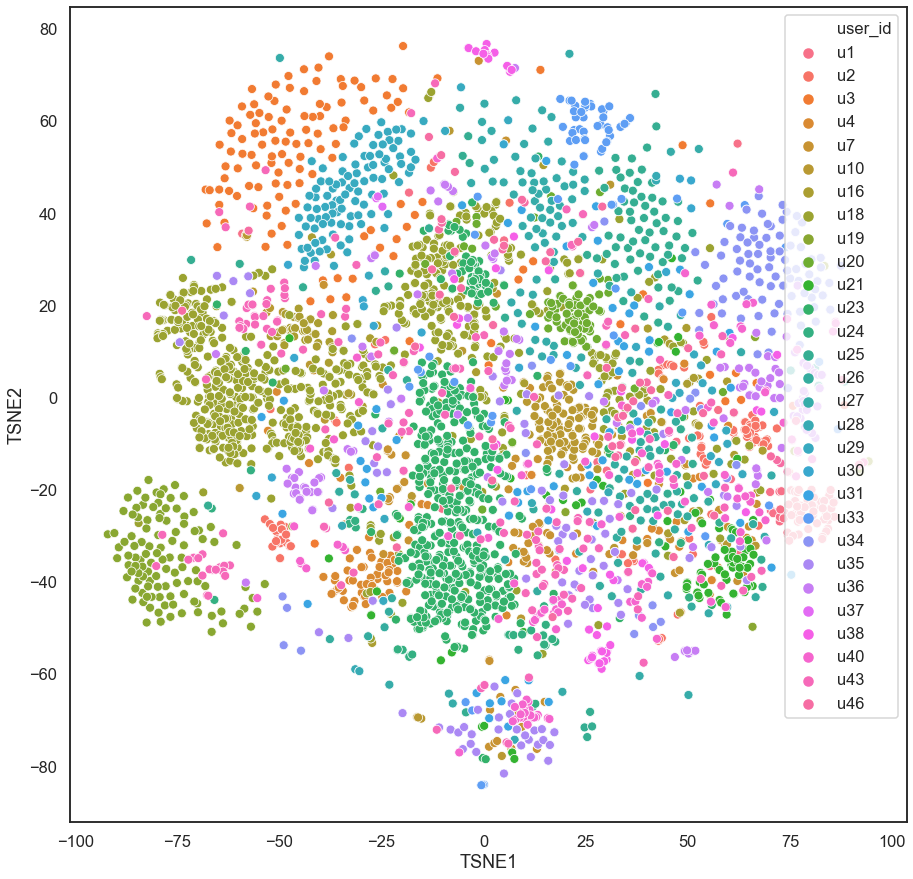

In [47]:
df = normed.reset_index()
df["user_id"] = "u" + df["user_id"].astype(str)
f, ax = plt.subplots(figsize=(15,15))
sns.scatterplot("TSNE1", "TSNE2", hue="user_id", data=df, ax=ax, legend="full")

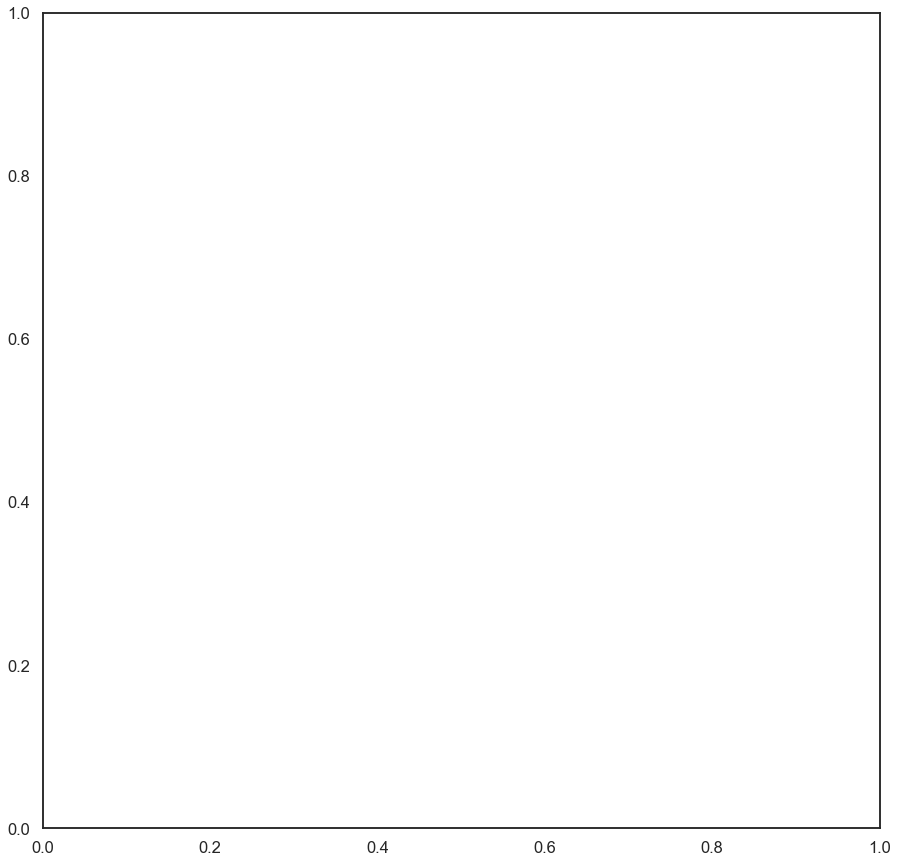

In [58]:


turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])




def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])